In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import norm, expon, norm
from scipy.optimize import minimize

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# import the LSTM model specified by PyTorch
from LSTM_model import LSTM_regression
from LSTMJOIN_model import LSTM_MultiTask

from sklearn.mixture import GaussianMixture

df1 = pd.read_csv("ogd-smn_gve_h_historical_2000-2009.csv", sep=";")
df2 = pd.read_csv("ogd-smn_gve_h_historical_2010-2019.csv", sep=";")

df = pd.concat([df1, df2], axis=0)

conversion = {
    'tre200h0' : '2m air T hourly mean',
    'tre005h0' : 'air T ground hourly mean',
    'ure200h0' : '2m rel hum hourly mean',
    'pva200h0' : '2m vap pres hourly mean',
    'dkl010h0' : 'wind direction hourly mean',
    'fkl010h0' : 'wind speed (ms) hourly mean',
    'rre150h0' : 'cumulative precipitation',
    'gre000h0' : 'global irradiance',
    'sre000h0' : 'total sunshine'
 }

fets_sel = list(conversion.keys())
fets_sel = ["reference_timestamp"] + fets_sel

df = df[fets_sel]

# and then replacce the name
df = df.rename(columns=conversion)

# let's take the referece time as datetime
df["reference_timestamp"] = pd.to_datetime(df["reference_timestamp"], format="%d.%m.%Y %H:%M")

df = df.dropna()

In [ ]:
#df = df[(df['cumulative precipitation'] < 2) & (df['cumulative precipitation'] >0)]
print(df['cumulative precipitation'].value_counts())
df['cumulative precipitation'] = np.sqrt( np.log1p(df['cumulative precipitation']))
df['cumulative precipitation'].plot(kind='hist', bins=20)
plt.show()

cumulative precipitation
0.0     155255
0.1       4636
0.2       2386
0.3       1650
0.4       1248
         ...  
12.6         1
12.7         1
11.0         1
24.1         1
21.9         1
Name: count, Length: 150, dtype: int64


AttributeError: module 'numpy' has no attribute 'logp1'

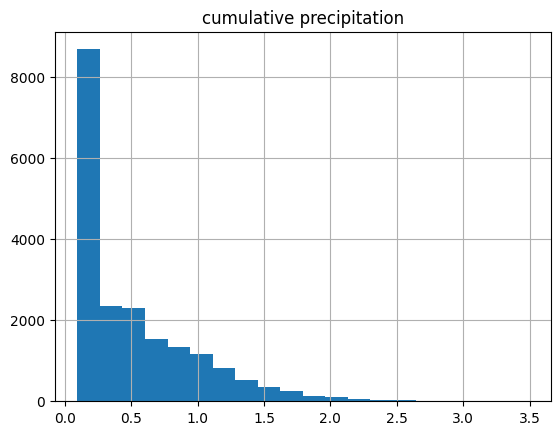

In [19]:
df = df[df['cumulative precipitation'] > 0]
df['cumulative precipitation'] = np.log1p(df['cumulative precipitation'])
df.hist('cumulative precipitation', bins=20)
plt.show()

[0.51633269 1.92603456 0.99275442]


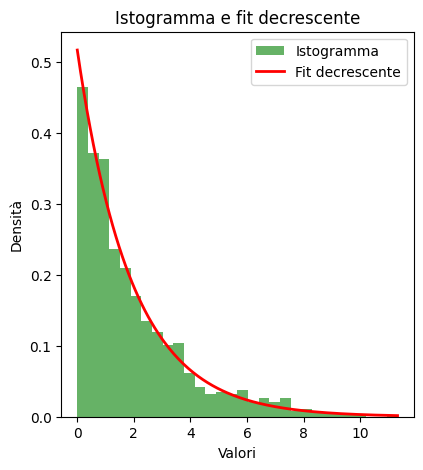

In [34]:
from scipy.optimize import curve_fit
import numpy as np

def decrescente(x, A, tau, alpha):
    return A * np.exp(-(x/tau)**alpha)

# dati di esempio
data = np.random.exponential(scale=2, size=1000)

hist, bin_edges = np.histogram(data, bins=30, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# parametri iniziali più realistici
p0 = [max(hist), np.mean(data), 1.5]  

# fit con più tentativi
popt, _ = curve_fit(
    decrescente, bin_centers, hist, 
    p0=p0, 
    bounds=([0, 0, 0], [np.inf, np.inf, 5]),
    maxfev=5000
)

print(popt)

x_fit = np.linspace(min(data), max(data), 200)
y_fit = decrescente(x_fit, *popt)

# residui tra istogramma e curva stimata
residuals = hist - decrescente(bin_centers, *popt)

# plot istogramma e curva fit
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.hist(data, bins=30, density=True, alpha=0.6, color='g', label='Istogramma')
plt.plot(x_fit, y_fit, 'r-', lw=2, label='Fit decrescente')
plt.xlabel('Valori')
plt.ylabel('Densità')
plt.title('Istogramma e fit decrescente')
plt.legend()



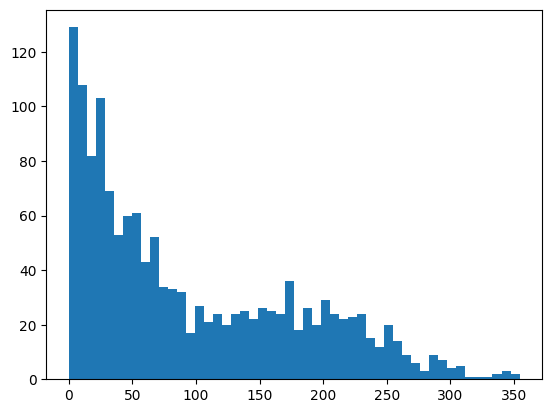

Parametri stimati:
mu = 109.03706084395942
sigma = 86.88017500246119
scale esponenziale = 95.80026761811085
peso gaussiana w = 0.001


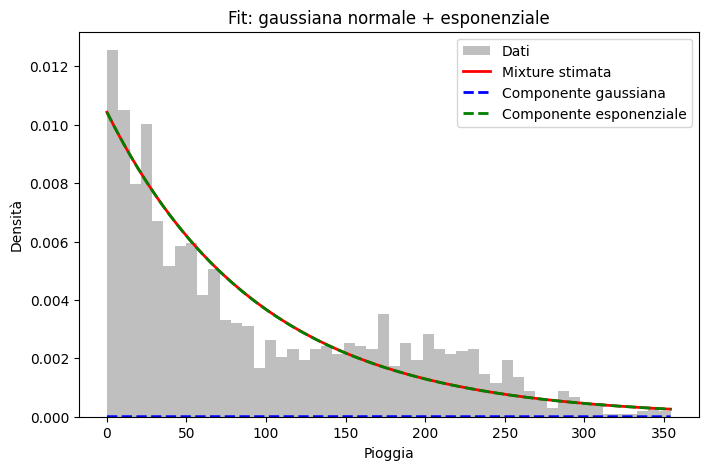

In [ ]:
import numpy as np
import pandas as pd

# Esempio di dati (sostituisci con i tuoi dati reali)
rain_exp = np.random.exponential(scale=50, size=1000)
rain_gau = np.random.normal(loc=200, scale=50, size=450)

rain = np.concatenate([rain_exp, rain_gau])

plt.hist(rain, bins=50)
plt.show()

# -------------------
# 2. Funzione densità della miscela
# -------------------
def mixture_pdf(x, mu, sigma, scale_exp, w):
    gauss_density = norm.pdf(x, loc=mu, scale=sigma)
    exp_density = expon.pdf(x, scale=scale_exp)
    return w*gauss_density + (1-w)*exp_density

# -------------------
# 3. Funzione log-likelihood negativa
# -------------------
def neg_log_likelihood(params, data):
    mu, sigma, scale_exp, w = params
    if sigma <= 0 or scale_exp <= 0 or w <= 0 or w >= 1:
        return np.inf
    pdf_vals = mixture_pdf(data, mu, sigma, scale_exp, w)
    pdf_vals = np.clip(pdf_vals, 1e-12, None)  # evitare log(0)
    return -np.sum(np.log(pdf_vals))

# -------------------
# 4. Fit dei parametri
# -------------------
init_params = [np.mean(rain), np.std(rain), 1.0, 0.3]
result = minimize(neg_log_likelihood, init_params, args=(rain,),
                  bounds=[(None,None),(1e-3,None),(1e-3,None),(1e-3,0.999)])

mu_est, sigma_est, scale_exp_est, w_est = result.x
print("Parametri stimati:")
print("mu =", mu_est)
print("sigma =", sigma_est)
print("scale esponenziale =", scale_exp_est)
print("peso gaussiana w =", w_est)

# -------------------
# 5. Plot dei risultati
# -------------------
x = np.linspace(min(rain), max(rain), 1000)
gauss_density = norm.pdf(x, loc=mu_est, scale=sigma_est)
exp_density = expon.pdf(x, scale=scale_exp_est)
mixture_density = w_est*gauss_density + (1-w_est)*exp_density

plt.figure(figsize=(8,5))
plt.hist(rain, bins=50, density=True, alpha=0.5, color='gray', label='Dati')
plt.plot(x, mixture_density, 'r-', lw=2, label='Mixture stimata')
plt.plot(x, w_est*gauss_density, 'b--', lw=2, label='Componente gaussiana')
plt.plot(x, (1-w_est)*exp_density, 'g--', lw=2, label='Componente esponenziale')
plt.xlabel("Pioggia")
plt.ylabel("Densità")
plt.title("Fit: gaussiana normale + esponenziale")
plt.legend()
plt.show()

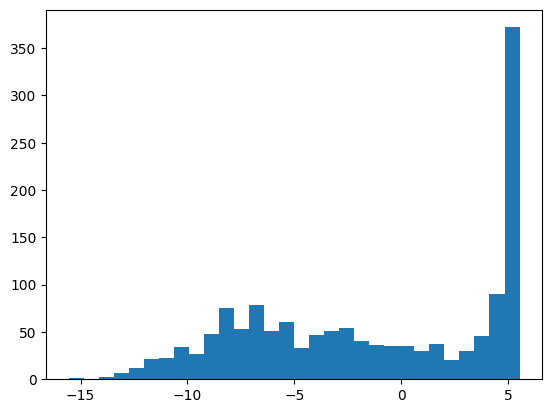

In [61]:
# separiamo le parti

gauss_pdf = norm.pdf(rain, loc=mu_est, scale=sigma_est)
exp_pdf = expon.pdf(rain, scale=scale_exp_est)

# Probabilità di appartenenza alla componente gaussiana
p_gauss = (w_est * gauss_pdf) / (w_est * gauss_pdf + (1 - w_est) * exp_pdf)

# Stima della parte gaussiana e della parte residua (esponenziale)
rain_gauss = p_gauss * rain
rain_resid = rain - rain_gauss
rain_resid = np.log(rain_resid)
plt.hist(np.log(rain_gauss), bins=30)
plt.show()